In [571]:
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
import torch.nn.functional as F
from torch_geometric.nn import GINConv,GCNConv
from torch_geometric.nn import global_add_pool, global_mean_pool,global_max_pool
import matplotlib.pyplot as plt
import numpy as np

# Mean Pooling

In [572]:
class GNN_mean(torch.nn.Module):
    def __init__(self, dim_h, num_layers):
        super(GNN_mean, self).__init__()
        self.layers = torch.nn.ModuleList()
        
        if(num_layers > 1):
            self.layers.append(GCNConv(dataset.num_node_features, dim_h))
            for i in range(1,num_layers):
                self.layers.append(GCNConv(dim_h, dim_h))
        else:
            self.layers.append(GCNConv(dataset.num_node_features, dataset.num_classes))
        self.lin = Linear(dim_h, dataset.num_classes)

    def forward(self, x, edge_index, batch,num_layers):
        
        h = x
        for i in range(num_layers):
            h = (self.layers[i](h, edge_index)).relu()
                

        hG = global_mean_pool(h, batch)

        h = F.dropout(hG, p=0.5, training=self.training)
        
        if(num_layers > 1):
            h = self.lin(h)
        
        return hG, F.log_softmax(h, dim=1)


# MaxPooling

In [573]:
class GNN_max(torch.nn.Module):
    def __init__(self, dim_h, num_layers):
        super(GNN_max, self).__init__()
        self.layers = torch.nn.ModuleList()
        
        if(num_layers > 1):
            self.layers.append(GCNConv(dataset.num_node_features, dim_h))
            for i in range(1,num_layers):
                self.layers.append(GCNConv(dim_h, dim_h))
    
        else:
            self.layers.append(GCNConv(dataset.num_node_features, dataset.num_classes))
        self.lin = Linear(dim_h, dataset.num_classes)

    def forward(self, x, edge_index, batch,num_layers):
        
        h = x
        for i in range(num_layers):
            h = (self.layers[i](h, edge_index)).relu()
                

        hG = global_max_pool(h, batch)

        h = F.dropout(hG, p=0.5, training=self.training)
        
        if(num_layers > 1):
            h = self.lin(h)
        
        return hG, F.log_softmax(h, dim=1)


# GIN

In [574]:
class GIN(torch.nn.Module):
    def __init__(self, dim_h, num_layers):
        super(GIN, self).__init__()
        self.layers = torch.nn.ModuleList()
        
        self.layers.append(GINConv(Sequential(Linear(dataset.num_node_features, dim_h),
                           BatchNorm1d(dim_h), ReLU(),
                           Linear(dim_h, dim_h), ReLU())))
        for i in range(1,num_layers):
            self.layers.append(GINConv(Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                                   Linear(dim_h, dim_h), ReLU())))
        self.fin = Linear(dim_h*num_layers, dim_h*num_layers)
        self.out = Linear(dim_h*num_layers, dataset.num_classes)
            


    def forward(self, x, edge_index, batch, num_layers):
        h = x
        for i in range(num_layers):
            h = self.layers[i](h, edge_index) 
            h_sum = global_add_pool(h, batch)
            if(i == 0):
                h_fin = h_sum
            else:
                h_fin = torch.cat((h_fin,h_sum), dim=1)

        
        h_fin = (self.fin(h_fin)).relu()
        h_fin = F.dropout(h_fin, p=0.5, training=self.training)
        h_fin = self.out(h_fin)
        
        return h_fin, F.log_softmax(h_fin, dim=1)
    

# Training & Testing

In [575]:
def train(model, loader,num_layers, test_loader):
    test_fin = []
    train_fin = []
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.01,weight_decay=0.01)
    epochs = 100
    train_acc=[]
    model.train()
    for epoch in range(epochs+1):
        acc = 0
        tot = 0

        for data in loader:
            optimizer.zero_grad()
            _, out = model(data.x, data.edge_index, data.batch, num_layers)
            loss = criterion(out, data.y)
            acc += (out.argmax(dim=1) == data.y).sum()
            loss.backward()
            optimizer.step()
            tot = tot + len(data.y)
        train_acc.append(acc/(tot))

    print((np.mean(train_acc)).item())
    train_fin.append((np.mean(train_acc)).item())
    test_acc = test(model, test_loader,num_layers)
    print(test_acc.item())
    test_fin.append(test_acc.item())
    
    return model,train_fin,test_fin

@torch.no_grad()
def test(model, loader, num_layers):
    
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    acc = 0
    tot = 0

    for data in loader:
        _, out = model(data.x, data.edge_index, data.batch, num_layers)
        acc += (out.argmax(dim=1) == data.y).sum()
        tot = tot+len(data.y)
    acc = acc/tot
    
    return acc

# Accuracies for different Datasets

In [576]:
def test_datasets(dataset, name):
    train_dataset = dataset[:int(len(dataset)*0.8)]
    test_dataset  = dataset[int(len(dataset)*0.8):]

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    test_fin = []
    train_fin = []
    
    num_layers = [1,3]
    
    for num in num_layers:
        
        gnn_max = GNN_max(dim_h=32,num_layers=num)
        gnn_mean = GNN_mean(dim_h=32,num_layers=num)
        gin = GIN(dim_h=32, num_layers=num)

        gnn_max,train1,test1 = train(gnn_max, train_loader, num,test_loader)
        gnn_mean,train2,test2 = train(gnn_mean, train_loader, num, test_loader)
        gin,train3,test3 = train(gin, train_loader, num, test_loader)
    
        train_fin.append(train1)
        train_fin.append(train2)
        train_fin.append(train3)
        test_fin.append(test1)
        test_fin.append(test2)
        test_fin.append(test3)


    fig = plt.figure(figsize=(15,5))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) 

    ax.plot(train_fin)
    ax.plot(test_fin)

    ax.set_xlabel('Model')
    ax.set_ylabel('Accuracy')
    ax.set_title(name)
    ax.set_xticks([0,1,2,3,4,5])
    ax.set_xticklabels(['Max-1-Layer','Mean-1-Layer','Sum-1-Layer','Max-MLP','Mean-MLP','Sum-MLP'])
    ax.legend(["Training", "Testing"], loc ="lower right")

    plt.show()

0.4865346848964691
0.7105262875556946
0.5018482208251953
0.7105262875556946
0.7884490489959717
0.8157894611358643
0.6527391672134399
0.7105262875556946
0.6586138010025024
0.7105262875556946
0.8640263676643372
0.7105262875556946


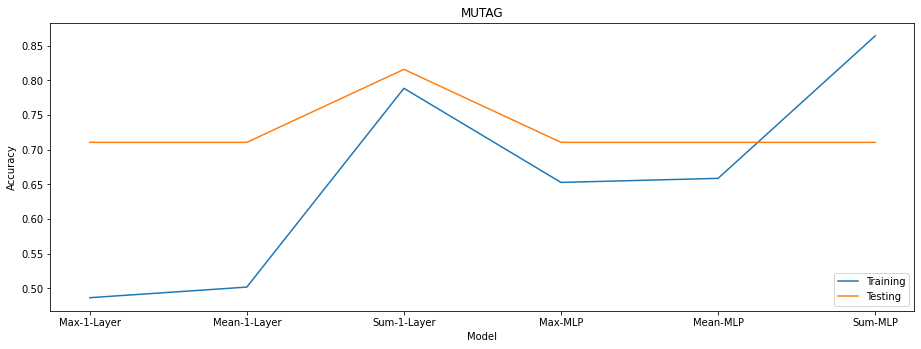

0.5015026330947876
0.6180048584938049
0.5049715638160706
0.510948896408081
0.6878538131713867
0.6666666865348816
0.495991975069046
0.510948896408081
0.4965009391307831
0.510948896408081
0.688877522945404
0.6897810101509094


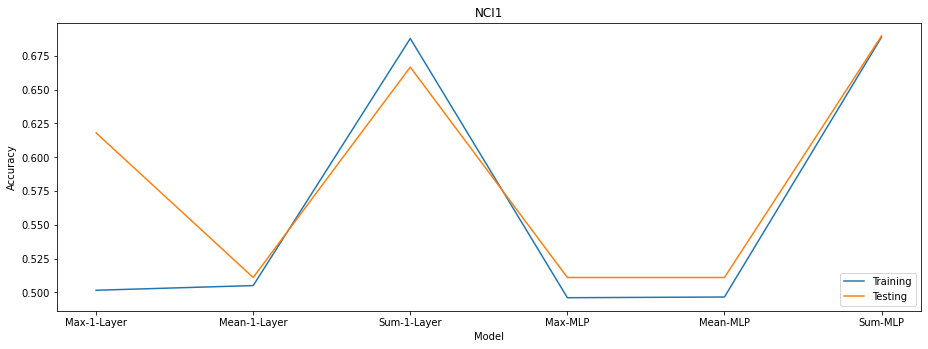

0.5989542007446289
0.5695067048072815
0.5402380228042603
0.5695067048072815
0.7305261492729187
0.7443946003913879
0.6260095238685608
0.5695067048072815
0.6021803617477417
0.5695067048072815
0.7291466593742371
0.7578475475311279


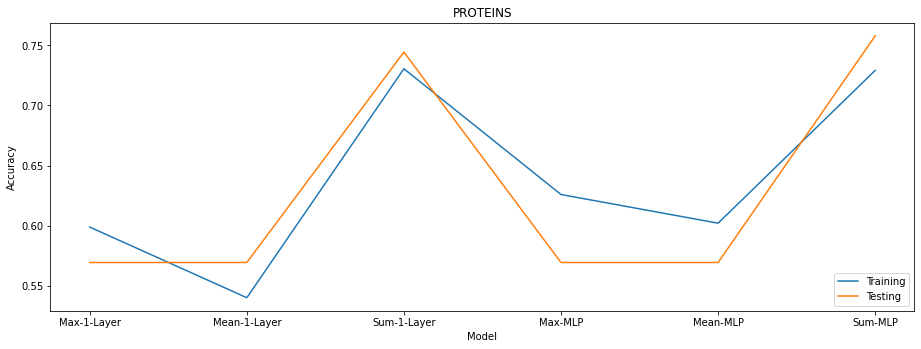

In [577]:
dataset_name = ['MUTAG','NCI1', 'PROTEINS']
for name in dataset_name:
    dataset = TUDataset(root='.', name=name).shuffle()
    test_datasets(dataset,name)